# Data Parameter Estimation for a Single Unit - Economizer

This notebook demonstrates parameter estimation continuing from the data reconciliation results in ```econ_recon.ipynb``` or ```boiler_recon.ipynb```.

## 1. Read Data

The data used here is produced by the data reconciliation step.  The data tags are mostly systematically generated from stream names to minimize effort in mapping data to the model.  The same model is used for parameter reconciliation and data reconciliation, so the stream names are consistent and any data mapping can be reused.  The bin information columns where included in the data reconciliation output, so there is no need to bin the data again here.

In [1]:
import pandas as pd
import idaes.dmf.model_data as da

Either economizer only or full boiler data reconciliation results can be used here.  You can select below. 

In [2]:
recon_data = "econ_recon.csv"

#Uncomment the next line to use boiler recon data.
#redon_data = "boiler_recon.csv"

In [3]:
# Since the data is already tagged to match the model and in the correct units, we directly read the data
# into a Pandas data frame, and there is no need to use the data processing functions that were used in the
# data reconciliation notebook (although they could be used here). 
df = pd.read_csv(recon_data)

# Calculate the standard deviations of the binned data 
bin_stdev = da.bin_stdev(df, bin_no="bin_no")

Create a function to set the model data.  In this case, we take the data reconciliation results for model input to be correct and set those in the model.  Another approach would be to also estimate model inputs given that there is some uncertainty in their measurements.

In [4]:
# The 'set_data' function below takes data from the DataFrame and updates the model data parameters.
def set_data(m, df, data_tags, index=None, indexindex=None):
    if index is None:
        index = df.index[indexindex]
    m.bin_no = df.iloc[index]["bin_no"]
    for t in data_tags:
        m.data[t] = df.iloc[index][t]
        m.data_stdev[t] = bin_stdev[m.bin_no][t]
    # Set the inlet streams from the data.
    input_tags = [
        "BFW_h",
        "BFW_P",
        "BFW_F",
        "FG_2_ECON_T",
        "FG_2_ECON_P",
        "FG_2_ECON_F[O2]",
        "FG_2_ECON_F[NO]",
        "FG_2_ECON_F[N2]",
        "FG_2_ECON_F[SO2]",
        "FG_2_ECON_F[CO2]",
        "FG_2_ECON_F[H2O]",
    ]
    for t in input_tags:
        m.data_tags[t].value = df.iloc[index][t]

## 2.  Create Model Generator Function

We use the Parmest tool from Pyomo to do the parameter estimation here, which requires a function to generate a model for each case.  The cases are put together by Parmest to set up a parameter estimation problem.

In [5]:
# Import models
import os
import pyomo.environ as pyo
from idaes.core.util import model_serializer as ms
from idaes.core import FlowsheetBlock
from idaes.power_generation.properties.IdealProp_FlueGas import FlueGasParameterBlock
from idaes.power_generation.unit_models.boiler_heat_exchanger import (
    BoilerHeatExchanger, 
    TubeArrangement, 
    DeltaTMethod
)
from idaes.generic_models.properties import iapws95
import idaes.core.util.tables as ta

In [6]:
# Add a function to get an instance of the economizer model.

solver = pyo.SolverFactory('ipopt')
def get_model(data=0):
    m = pyo.ConcreteModel()
    m.fs = FlowsheetBlock(default={"dynamic": False})
    m.fs.prop_water = iapws95.Iapws95ParameterBlock()
    m.fs.prop_fluegas = FlueGasParameterBlock()

    m.fs.econ = BoilerHeatExchanger(default={
            "side_1_property_package": m.fs.prop_water,
            "side_2_property_package": m.fs.prop_fluegas,
            "has_pressure_change": True,
            "has_holdup": False,
            "delta_T_method": DeltaTMethod.counterCurrent,
            "tube_arrangement": TubeArrangement.inLine,
            "side_1_water_phase": "Liq",
            "has_radiation": False
        }
    )
    # Set inputs and initialize.  Since the initialization is repeated each time a
    # model is created, we'll save the results and reload them.
    if os.path.isfile("econ_init.json.gz"):
        ms.from_json(m, fname="econ_init.json.gz")
    else:
        h = iapws95.htpx(563.706, 2.5449e7)
        m.fs.econ.side_1_inlet.flow_mol[0].fix(24678.26) # mol/s
        m.fs.econ.side_1_inlet.enth_mol[0].fix(h) #J/mol         
        m.fs.econ.side_1_inlet.pressure[0].fix(2.5449e7) # Pa

        # Set the flue gas flow and composition
        fg_rate = 28.3876e3  # mol/s equivalent of ~1930.08 klb/hr
        fg_comp = { # mol fraction of flue gas components
            "H2O":8.69/100,
            "CO2":14.49/100,
            "O2":2.47/100,
            "NO":0.0006,
            "SO2":0.002,
        }
        # The rest is N2
        fg_comp["N2"] = 1 - sum(fg_comp[i] for i in fg_comp)

        # Set economizer inlets
        for c in fg_comp:
            m.fs.econ.side_2_inlet.flow_component[0, c].fix(fg_rate*fg_comp[c])    
        m.fs.econ.side_2_inlet.temperature[0].fix(682.335)  # K
        m.fs.econ.side_2_inlet.pressure[0].fix(100145)  # Pa

        # Set economizer design variables and parameters
        ITM = 0.0254  # inch to meter conversion
        # Based on NETL Baseline Report Rev4
        m.fs.econ.tube_thickness.fix(0.188*ITM)  # tube thickness
        m.fs.econ.tube_di.fix((2.0 - 2.0 * 0.188)*ITM) # calc inner diameter
        m.fs.econ.pitch_x.fix(3.5*ITM)
        m.fs.econ.pitch_y.fix(5.03*ITM)
        m.fs.econ.tube_length.fix(53.41*12*ITM)  # use tube length (53.41 ft)
        m.fs.econ.tube_nrow.fix(36*2.5) # use to match baseline performance
        m.fs.econ.tube_ncol.fix(130) # 130 from thermoflow
        m.fs.econ.nrow_inlet.fix(2)
        m.fs.econ.delta_elevation.fix(50)
        m.fs.econ.tube_r_fouling = 0.000176
        m.fs.econ.shell_r_fouling = 0.00088
        m.fs.econ.fcorrection_htc.fix(1.5)
        m.fs.econ.fcorrection_dp_tube.fix(1.0)
        m.fs.econ.fcorrection_dp_shell.fix(1.0)
        m.fs.econ.initialize(
            state_args_1={
                "flow_mol": m.fs.econ.side_1_inlet.flow_mol[0].value,
                "pressure": m.fs.econ.side_1_inlet.pressure[0].value,
                "enth_mol": m.fs.econ.side_1_inlet.enth_mol[0].value,
            },
            state_args_2={
                "flow_component":{
                    "H2O": m.fs.econ.side_2_inlet.flow_component[0, "H2O"].value,
                    "CO2": m.fs.econ.side_2_inlet.flow_component[0, "CO2"].value,
                    "N2": m.fs.econ.side_2_inlet.flow_component[0, "N2"].value,
                    "O2": m.fs.econ.side_2_inlet.flow_component[0, "O2"].value,
                    "NO": m.fs.econ.side_2_inlet.flow_component[0, "NO"].value,
                    "SO2": m.fs.econ.side_2_inlet.flow_component[0, "SO2"].value,
                },
                "temperature": m.fs.econ.side_2_inlet.temperature[0].value,
                "pressure": m.fs.econ.side_2_inlet.pressure[0].value,
            }
        )
        ms.to_json(m, fname="econ_init.json.gz")
    
    #Add tags and data parameters
    stream_dict = ta.arcs_to_stream_dict(
        m, 
        additional={
            "BFW": m.fs.econ.side_1_inlet,
            "ECON_OUT": m.fs.econ.side_1_outlet,
            "FG_2_ECON": m.fs.econ.side_2_inlet,
            "FG_2_AIRPH": m.fs.econ.side_2_outlet,
        },
        sort=True,
    )
    state_dict = ta.stream_states_dict(stream_dict, time_point=0)
    m.data_tags = ta.tag_state_quantities(
        blocks=state_dict, 
        attributes=(
            "flow_mass", 
            "flow_mol", 
            "enth_mol", 
            "temperature", 
            "pressure", 
            ("flow_component", "O2"),
            ("flow_component", "NO"),
            ("flow_component", "N2"),
            ("flow_component", "SO2"),
            ("flow_component", "CO2"),
            ("flow_component", "H2O"),
        ), 
        labels=("_Fm", "_F", "_h", "_T", "_P", "_F[O2]", "_F[NO]", "_F[N2]", "_F[SO2]", "_F[CO2]", "_F[H2O]"),
    )
    m.data_tags["ECON_Q"] = m.fs.econ.heat_duty[0]
    
    m.data = pyo.Param(m.data_tags, mutable=True, doc="Process data for a specific point in time.")
    m.data_stdev = pyo.Param(m.data_tags, mutable=True, doc="Process data standard deviation.")
    @m.Expression(m.data_tags)
    def err(m, i):
        return (m.data[i] - m.data_tags[i])/m.data_stdev[i]    

    # Set the data
    set_data(m, df, data_tags=m.data_tags, index=data)
    solver.solve(m)

    return m

In [7]:
# Try the get model function
solver = pyo.SolverFactory('ipopt')
print(df.index)
m = get_model(0)

# Solve the model at the first data point
solver.solve(m)

RangeIndex(start=0, stop=290, step=1)


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 118, 'Number of variables': 118, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.05605936050415039}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

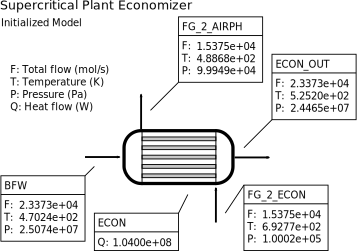

In [8]:
# Show the model result at the first data point
from idaes.core.util.misc import svg_tag  # utility to place numbers/text in an SVG
from IPython.display import SVG, display

with open("econ.svg", "r") as f:
    s = svg_tag(svg=f, tags={"subtitle":"Initialized Model"})
    s = svg_tag(svg=s, tags=m.data_tags, outfile="econ_init.svg")
display(SVG(s))

In [9]:
import pytest

In [10]:
assert pyo.value(m.data_tags["ECON_Q"]) == pytest.approx(1.0400e8, rel=1e-4)

## 3. Set Up Parameter Estimation

Here we use the Parmest tool to solve the parameter estimation problem.  The theta_names list is a list of parameters to estimate.  The theta names strings are the location of the parameters in the model.  A function ```sse()``` is also defined that creates the objective function for each model instance.  The objective from the individual cases is summed to produce the overall parameter estimation objective.

In [11]:
# List of parameters to estimate
theta_names = [
    "fs.econ.fcorrection_htc",
    "fs.econ.fcorrection_dp_tube",
    "fs.econ.fcorrection_dp_shell",
]

# Tags to include in the objective
objective_tags = {
    "ECON_OUT_P", 
    "ECON_OUT_T", 
    "FG_2_AIRPH_T", 
    "FG_2_AIRPH_P",
}

# Return expressions for the objective
def sse(model, data):
    return sum((model.err[i])**2 for i in objective_tags)

Run Parmest and record the results.  Here we group the data by bin.  Each parameter in theta_names will be estimated based on all the points in a bin.  This will allow us to examine whether the parameters have a dependence on load.

In [12]:
import pyomo.contrib.parmest.parmest as parmest
import numpy as np

parmest_results={}
# run parmest tool for each power bin
for i, group in df.groupby("bin_no"):
    pest = parmest.Estimator(get_model, list(group.index), theta_names, sse)
    obj, theta = pest.theta_est()
    print(f"Bin number: {i},  objective: {obj}")
    for k in theta:
        print(f"  {k}: {theta[k]}")
    parmest_results[i] = {'obj':obj, 'theta': theta}

Bin number: 0.0,  objective: 178.59513109926215
  fs.econ.fcorrection_dp_shell: -0.7989794944514491
  fs.econ.fcorrection_dp_tube: 0.989998063932658
  fs.econ.fcorrection_htc: 1.325122950530284
Bin number: 1.0,  objective: 54.69636381017666
  fs.econ.fcorrection_dp_shell: 0.9358594763370965
  fs.econ.fcorrection_dp_tube: 1.0266714838301763
  fs.econ.fcorrection_htc: 1.491497803789623
Bin number: 2.0,  objective: 2.8996117873336416
  fs.econ.fcorrection_dp_shell: 0.5787793391135309
  fs.econ.fcorrection_dp_tube: 0.9748122496695127
  fs.econ.fcorrection_htc: 1.496981821576463
Bin number: 3.0,  objective: 66.4389030353446
  fs.econ.fcorrection_dp_shell: 0.8595394510588616
  fs.econ.fcorrection_dp_tube: 0.9981129558865275
  fs.econ.fcorrection_htc: 1.4178596771429535
Bin number: 4.0,  objective: 84.49063381926847
  fs.econ.fcorrection_dp_shell: -0.615580908473992
  fs.econ.fcorrection_dp_tube: 1.0618499126610867
  fs.econ.fcorrection_htc: 1.4976038539649483
Bin number: 5.0,  objective: 3.9

In [13]:
# Save results
import json

with open("econ_parmest_result.json", "w") as f:
    json.dump(parmest_results, f)

In [14]:
for b in parmest_results:
    assert parmest_results[b]["theta"]["fs.econ.fcorrection_htc"] > 1.32
    assert parmest_results[b]["theta"]["fs.econ.fcorrection_htc"] < 1.67